Link: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/vector-data-processing/spatial-joins-in-python-geopandas-shapely/

In [1]:
# Import libraries
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
from shapely.geometry import box
import geopandas as gpd
import earthpy as et

# Set working dir & get data
data = et.data.get_data('spatial-vector-lidar')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In [2]:
# Import data
data_path = os.path.join("data/spatial-vector-lidar")

country_bound_us = gpd.read_file(os.path.join(data_path, "usa", 
                                              "usa-boundary-dissolved.shp"))
                                 
state_bound_us = gpd.read_file(os.path.join(data_path, "usa", 
                                            "usa-states-census-2014.shp"))
                               
pop_places = gpd.read_file(os.path.join(data_path, "global", 
                                        "ne_110m_populated_places_simple", 
                                        "ne_110m_populated_places_simple.shp"))
                                        
ne_roads = gpd.read_file(os.path.join(data_path, "global", 
                                      "ne_10m_roads", "ne_10m_roads.shp"))

In [3]:
# Simplify the country boundary just a little bit to make this run faster
country_bound_us_simp = country_bound_us.simplify(.2, preserve_topology=True)

# Clip the roads to the US boundary - this will take about a minute to execute
roads_cl = gpd.clip(ne_roads, country_bound_us_simp)
roads_cl.crs = ne_roads.crs

# Dissolve states by region
regions_agg = state_bound_us.dissolve(by="region")

In [4]:
# Roads within region
roads_region = gpd.sjoin(roads_cl, 
                         regions_agg, 
                         how="inner", 
                         op='intersects')

# Notice once you have joins the data - you have attributes 
# from the regions_object (i.e. the region) attached to each road feature
roads_region[["featurecla", "index_right", "ALAND"]].head()

,featurecla,index_right,ALAND
1,Road,Midwest,143794747023
3,Road,Midwest,143794747023
6,Road,Midwest,143794747023
7,Road,Midwest,143794747023
54,Road,Midwest,143794747023


In [5]:
# Reproject to Albers for plotting
country_albers = country_bound_us.to_crs({'init': 'epsg:5070'})
roads_albers = roads_region.to_crs({'init': 'epsg:5070'})

/home/pavel/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


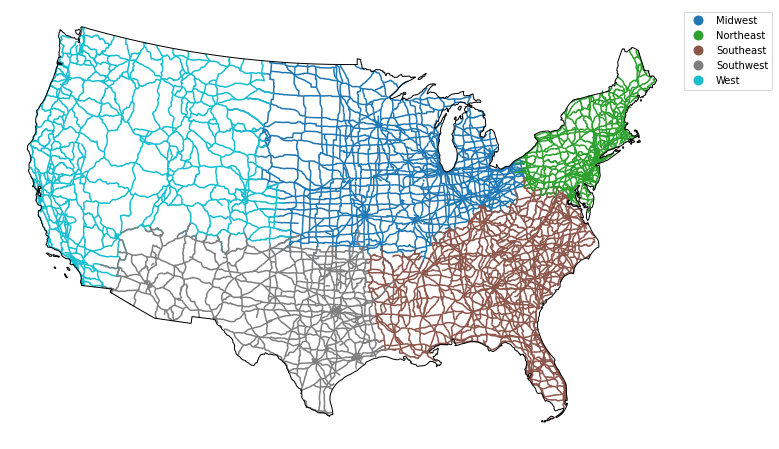

In [6]:
# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

country_albers.plot(alpha=1,
                    facecolor="none",
                    edgecolor="black",
                    zorder=10,
                    ax=ax)

roads_albers.plot(column='index_right',
                  ax=ax,
                  legend=True)

# Adjust legend location
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15,1))

ax.set_axis_off()
plt.axis('equal')
plt.show()

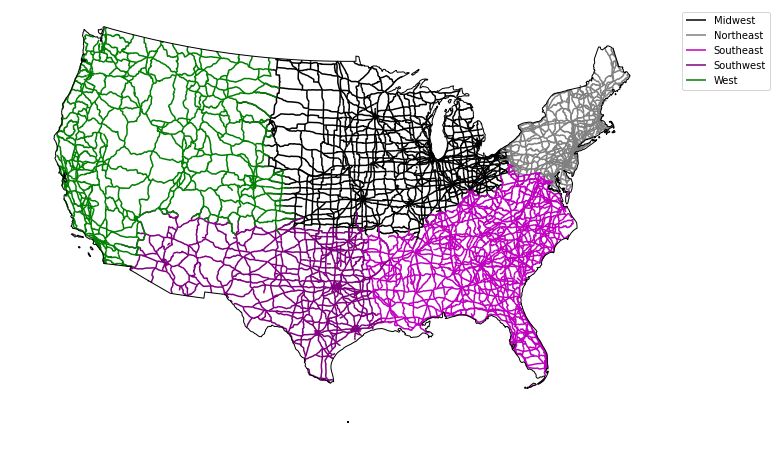

In [7]:
# First, create a dictionary with the attributes of each legend item
road_attrs = {'Midwest': ['black'],
              'Northeast': ['grey'],
              'Southeast': ['m'],
              'Southwest': ['purple'],
              'West': ['green']}

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

regions_agg.plot(edgecolor="black",
                 ax=ax)
country_albers.plot(alpha=1,
                    facecolor="none",
                    edgecolor="black",
                    zorder=10,
                    ax=ax)

for ctype, data in roads_albers.groupby('index_right'):
    data.plot(color=road_attrs[ctype][0],
              label=ctype,
              ax=ax)
    
# This approach works to place the legend when you have defined labels
plt.legend(bbox_to_anchor=(1.0, 1), loc=2)
ax.set_axis_off()
plt.axis('equal')
plt.show()

In [8]:
# Turn off scientific notation
pd.options.display.float_format = '{:.4f}'.format

# Calculate the total length of road 
road_albers_length = roads_albers[['index_right', 'length_km']]

# Sum existing columns
roads_albers.groupby('index_right').sum()

roads_albers['rdlength'] = roads_albers.length
sub = roads_albers[['rdlength', 'index_right']].groupby('index_right').sum()
sub

,rdlength
index_right,
Midwest,86575018.7717
Northeast,33786036.9011
Southeast,84343073.0339
Southwest,49373104.8209
West,61379832.9460
